# PyTorch Pressure Drop Regression 

## Neural Network Architecture

In [1]:
# Adjustments: Implemented AdamW instead of Adam and Dropout in the architecture
import torch 
import torch.nn as nn 

class DelpNN(nn.Module):
    def __init__(self):
        super(DelpNN, self).__init__()
        # Define the layers of the neural network
        self.fc1 = nn.Linear(6, 256)  # Increased the number of neurons in the first layer
        self.bn1 = nn.BatchNorm1d(256)  # Batch normalization for the first layer
        self.fc2 = nn.Linear(256, 128)  # Increased the number of neurons in the second layer
        self.bn2 = nn.BatchNorm1d(128)  # Batch normalization for the second layer
        self.fc3 = nn.Linear(128, 64)  # Adjusted the number of neurons in the third layer
        self.bn3 = nn.BatchNorm1d(64)  # Batch normalization for the third layer
        self.fc4 = nn.Linear(64, 32)   # Adjusted the number of neurons in the fourth layer
        self.bn4 = nn.BatchNorm1d(32)   # Batch normalization for the fourth layer
        self.fc5 = nn.Linear(32, 1)     # Output layer with a single neuron for regression
        self.relu = nn.ReLU()           # Activation function used between layers
        self.dropout1 = nn.Dropout(p=0.3)  # Dropout with a probability of 0.3
        self.dropout2 = nn.Dropout(p=0.4)  # Dropout with a probability of 0.4
        self.dropout3 = nn.Dropout(p=0.5)  # Dropout with a probability of 0.5
        self.dropout4 = nn.Dropout(p=0.5)  # Dropout with a probability of 0.5

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))  # Pass input through the first layer, apply batch normalization and ReLU activation
        x = self.dropout1(x)                  # Apply dropout
        x = self.relu(self.bn2(self.fc2(x)))  # Pass through the second layer, apply batch normalization and ReLU activation
        x = self.dropout2(x)                  # Apply dropout
        x = self.relu(self.bn3(self.fc3(x)))  # Pass through the third layer, apply batch normalization and ReLU activation
        x = self.dropout3(x)                  # Apply dropout
        x = self.relu(self.bn4(self.fc4(x)))  # Pass through the fourth layer, apply batch normalization and ReLU activation
        x = self.dropout4(x)                  # Apply dropout
        x = self.fc5(x)                       # Output layer produces final output, no activation (linear output)
        return x

## Load and Prepare Data 

In [2]:
import pandas as pd

def load_and_prepare_data(filepath):
    """
    Load data from a file for training a machine learning model and convert it into tensors without scaling.
    
    Args:
        filepath (str): Path to the data file. This file should be a whitespace-delimited text file and
                        can contain comments starting with '%'.

    Returns:
        tuple: A tuple containing two elements:
            - X_tensor (Tensor): Tensor containing the raw features.
            - Y_tensor (Tensor): Tensor containing the raw target variable.
            Returns (None, None) if an error occurs during file loading or data processing.
    """
    try:
        # Read the file, ignoring lines with '%', which are comments.
        data = pd.read_csv(filepath, delim_whitespace=True, comment='%', header=None)
        
        # Set custom column names for ease of access
        data.columns = ['HCC', 'WCC', 'LCC', 'Tamb', 'Uin', 'Q',
                        'Temperature1', 'Temperature2', 'Temperature3', 'Temperature4',
                        'Temperature5', 'Temperature6', 'Pressure1', 'Pressure2', 'Delp',
                        'Velocity1', 'Velocity2', 'Tsta', 'StackTemp2']
    except Exception as e:
        print(f"Error reading the data file: {e}")
        return None, None

    # Select specific columns for features and target
    feature_labels = ['HCC', 'WCC', 'LCC', 'Tamb', 'Uin', 'Q']
    X = data[feature_labels]
    Y = data['Delp']
    
    return X, Y

## Split Data

In [3]:
from sklearn.model_selection import train_test_split

def split_data(X, Y, test_size=0.2, random_state=42):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, Y_train, Y_test

## Preprocess Data

In [4]:
from sklearn.preprocessing import StandardScaler
import joblib
from torch.utils.data import DataLoader, TensorDataset

def preprocess_and_prepare_loaders(X_train, X_test, Y_train, Y_test, batch_size=64):
    scaler_X = StandardScaler()

    # Scale training data
    X_train_scaled = scaler_X.fit_transform(X_train)
    
    # Scale testing data using the same scaler
    X_test_scaled = scaler_X.transform(X_test)

    # Save the scaler for potential inverse transformations later
    joblib.dump(scaler_X, '6_scaler_X.pkl')

    # Convert scaled data to tensors. Use .values to correctly extract numpy arrays from pandas structures.
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

    # Ensure that Y_train and Y_test, if they are pandas Series, are converted to tensors properly.
    Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32).unsqueeze(1)
    Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32).unsqueeze(1)   # Use .values to extract the numpy array

    # Create TensorDataset and DataLoader
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Print samples of scaled data for verification
    print("Scaled Training Features Sample:")
    print(X_train_tensor[:5])
    print("Training Targets Sample:")
    print(Y_train_tensor[:5])
    print("Scaled Testing Features Sample:")
    print(X_test_tensor[:5])
    print("Testing Targets Sample:")
    print(Y_test_tensor[:5])

    return train_loader, test_loader

## Train Model

In [5]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=1000, patience=10):
    """
    Train a neural network model without learning rate scheduler.

    Args:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for training data.
        test_loader (DataLoader): DataLoader for validation data.
        criterion (Loss function): The loss function.
        optimizer (Optimizer): The optimizer.
        num_epochs (int): Maximum number of epochs to train.
        patience (int): Patience for early stopping.
    """
    model.train()
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        # Training phase
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = sum(criterion(model(inputs), labels).item() for inputs, labels in test_loader) / len(test_loader)

        # Early stopping check
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping after {epoch+1} epochs')
                break

        # Optional: Simplified logging
        if epoch % 10 == 0:  # Log every 10 epochs
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}')

    print('Training complete.')

## Evaluate Model

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, test_loader, criterion, filename='true_vs_predicted.png'):
    """
    Evaluate the performance of a trained neural network model.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (DataLoader): DataLoader for the test data.
        criterion (torch.nn.MSELoss): Loss function to use for evaluating the model.
    """
    model.eval()  # Set the model to evaluation mode.
    total_loss = 0
    total_rmse = 0
    predictions, actuals = [], []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in test_loader:
            outputs = model(inputs)  # Compute model output

            # Calculate loss for the batch directly with tensors
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            # Convert tensors to numpy for calculating RMSE and plotting
            outputs_np = outputs.detach().cpu().numpy()
            labels_np = labels.detach().cpu().numpy()

            # Calculate RMSE for each batch
            rmse = mean_squared_error(labels_np, outputs_np, squared=False)
            total_rmse += rmse * labels.size(0)

            # Store predictions and actuals for plotting
            predictions.extend(outputs_np.flatten())
            actuals.extend(labels_np.flatten())

    # Compute the average loss and RMSE
    mean_loss = total_loss / len(test_loader.dataset)
    mean_rmse = total_rmse / len(test_loader.dataset)
    relative_error = (mean_rmse / np.mean(actuals)) * 100  # Calculate relative error as a percentage
    r2 = r2_score(actuals, predictions)  # Calculate R^2 score

    # Print calculated metrics
    print(f'Test MSE: {mean_loss:.4f}')
    print(f'Test RMSE: {mean_rmse:.4f} Pa')
    print(f'Relative Error: {relative_error:.2f}%')
    print(f'R^2 Score: {r2:.4f}')  # Print R^2 score

    # Plot true vs predicted values
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman']
    rcParams['font.size'] = 12
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k-', label='Ideal Line')
    plt.xlabel('True Pressure Drop')
    plt.ylabel('Predicted Pressure Drop')
    plt.grid(True)

    # Save the figure as a PNG file
    plt.savefig(filename, format='png', bbox_inches='tight')

    plt.show()
    
    return mean_rmse

## Predict New Data

In [7]:
def predict_single_data_point(data_point, model_path, scaler_path):
    # Load the trained model
    model = DelpNN()
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode

    # Load the scaler
    scaler_X = joblib.load(scaler_path)

    # Scale the single data point
    data_point_scaled = scaler_X.transform([data_point])  # Note: [data_point] makes it 2D

    # Convert to tensor
    data_point_tensor = torch.tensor(data_point_scaled, dtype=torch.float32)

    # Make predictions
    with torch.no_grad():  # No need to track gradients for predictions
        output = model(data_point_tensor)

    prediction = output.numpy()  # Convert to numpy array if necessary

    return prediction

## Main 

Sample X (features):
     HCC     WCC   LCC    Tamb  Uin       Q
0  0.001  0.0005  0.03  253.15  1.0  1272.0
1  0.001  0.0005  0.03  273.15  1.0  1272.0
2  0.001  0.0005  0.03  293.15  1.0  1272.0
3  0.001  0.0005  0.03  313.15  1.0  1272.0
4  0.001  0.0005  0.03  253.15  1.0  3132.0
5  0.001  0.0005  0.03  273.15  1.0  3132.0
6  0.001  0.0005  0.03  293.15  1.0  3132.0
7  0.001  0.0005  0.03  313.15  1.0  3132.0
8  0.001  0.0005  0.03  253.15  1.0  5040.0
9  0.001  0.0005  0.03  273.15  1.0  5040.0
Sample Y (targets):
0     86.117
1     89.914
2     93.532
3     96.944
4     92.271
5     96.889
6    101.240
7    105.300
8     99.193
9    104.310
Name: Delp, dtype: float64
Sample of training features:
          HCC      WCC   LCC    Tamb    Uin       Q
3281  0.00200  0.00100  0.09  273.15   7.75  3132.0
2383  0.00175  0.00100  0.09  313.15   7.75  3132.0
2009  0.00175  0.00050  0.06  273.15   5.50  3132.0
2114  0.00175  0.00075  0.03  293.15   3.25  1272.0
1128  0.00125  0.00125  0.06 

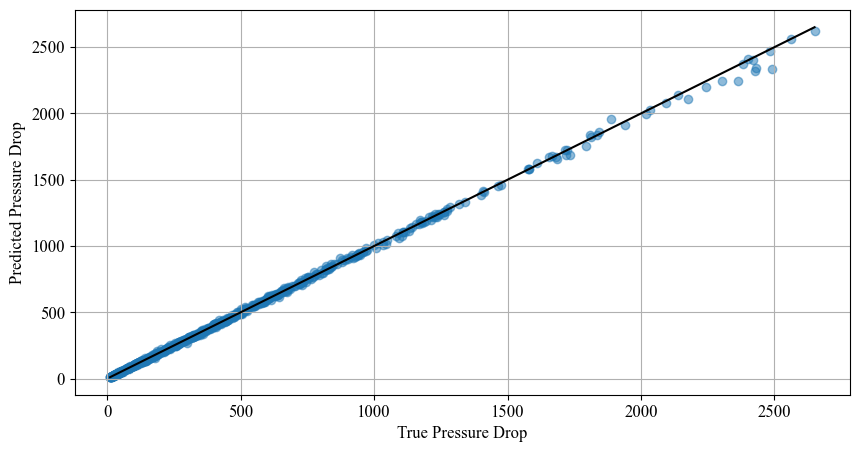

Model and scalers are saved successfully.


In [8]:
def main():
    # Main function to run the training and evaluation process.
    filepath = '/Users/hanheelee/Desktop/Projects/00_ML_Fuel_Cell/Set 1.txt'  # Path to data file
    X, Y = load_and_prepare_data(filepath)
    if X is None or Y is None:
        print("Failed to load data.")
        return
    
    # Print samples for verification
    print("Sample X (features):")
    print(X[:10])
    print("Sample Y (targets):")
    print(Y[:10])
    
    # Split data
    X_train, X_test, Y_train, Y_test = split_data(X,Y)
    
    # Print samples for verification
    print("Sample of training features:")
    print(X_train.head())
    print("Sample of training targets:")
    print(Y_train.head())
    print("Sample of testing features:")
    print(X_test.head())
    print("Sample of testing targets:")
    print(Y_test.head())

    # Prepare data loaders
    train_loader, test_loader = preprocess_and_prepare_loaders(X_train, X_test, Y_train, Y_test)
    
    # Create model instance
    model = DelpNN()  # Instantiate the model
    criterion = nn.L1Loss()  # Loss function for regression
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-4,
        betas=(0.9, 0.999),  # default betas for Adam
        eps=1e-08,  # small epsilon for numerical stability
        weight_decay=0.01,  # L2 regularization
        )
    
    # Train the model
    train_model(model, train_loader, test_loader, criterion, optimizer)
    
    # Evaluate the model
    mean_rmse = evaluate_model(model, test_loader, criterion)  # Pass the scaler_target to use for inverse scaling

    # Save the model's state dictionary and scalers
    filename = f'Delp_{mean_rmse:.4f}.pth'
    torch.save(model.state_dict(), filename)
    
    print("Model and scalers are saved successfully.")

if __name__ == "__main__":
    # Set fixed random number seed
    torch.manual_seed(42)
    main()  # Execute the main function if the script is run directly.